# Differential Test of CLgen kernels

Run CLgen kernels on two different devices using the same inputs.

Record any outputs which differ.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import clgen
from clgen import dbutil

import json

from labm8 import fs
from labm8 import viz

plt.style.use(["seaborn-white", "seaborn-paper"])

## 1. Experimental Results

Datasets:

In [2]:
!ls -lh data/difftest/

total 107M
-rw-r--r-- 1 cec cec  58M Mar 21 17:30 cpu.db
-rw-rw-r-- 1 cec cec 1.8M Mar 21 17:30 cpu.log
-rw-r--r-- 1 cec cec  46M Mar 21 17:30 gpu.db
-rw-rw-r-- 1 cec cec 2.1M Mar 21 17:30 gpu.log
drwxrwxr-x 2 cec cec 4.0K Mar 25 03:17 reports


Load datasets. Set `in1` and `in2` appropriately:

In [3]:
in1 = fs.path("data/difftest/cpu.db")
in2 = fs.path("data/difftest/gpu.db")

in1base = fs.basename(in1)
in2base = fs.basename(in2)

db1 = dbutil.connect(in1)
db2 = dbutil.connect(in2)

c1 = db1.cursor()
c2 = db2.cursor()

c1.execute("ATTACH DATABASE '{in2}' AS rhs".format(**vars()))
c2.execute("ATTACH DATABASE '{in1}' AS rhs".format(**vars()))

# num results
n1 = dbutil.num_rows_in(in1, "Data")
n2 = dbutil.num_rows_in(in2, "Data")

# metadata
device1 = dbutil.get_meta(in1, "device")
device2 = dbutil.get_meta(in2, "device")

host1 = dbutil.get_meta(in1, "host")
host2 = dbutil.get_meta(in2, "host")

c1.execute("""
SELECT COUNT(*)
FROM Data AS lData INNER JOIN rhs.Data AS rData ON lData.id=rData.id
""")
n3 = c1.fetchone()[0]

c1.execute("""
SELECT
    lData.id AS id,
    lData.status AS lstatus, rData.status AS rstatus,
    lData.result AS ldata, rData.result AS rdata
FROM Data AS lData INNER JOIN rhs.Data AS rData ON lData.id=rData.id
WHERE lData.result != "" AND rData.result != ""
""")
cdata = c1.fetchall()
ncdata = len(cdata)

print("""\
Number of results for {device1} on {host1}: {n1}.
Number of results for {device2} on {host2}: {n2}.
Number of common results: {n3}.
Number of common good results: {ncdata}.\
""".format(**vars()))

Number of results for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz on cc1: 13489.
Number of results for GeForce GTX 1080 on cc1: 18070.
Number of common results: 5129.
Number of common good results: 940.


## 2. Evaluation

### Per-device results

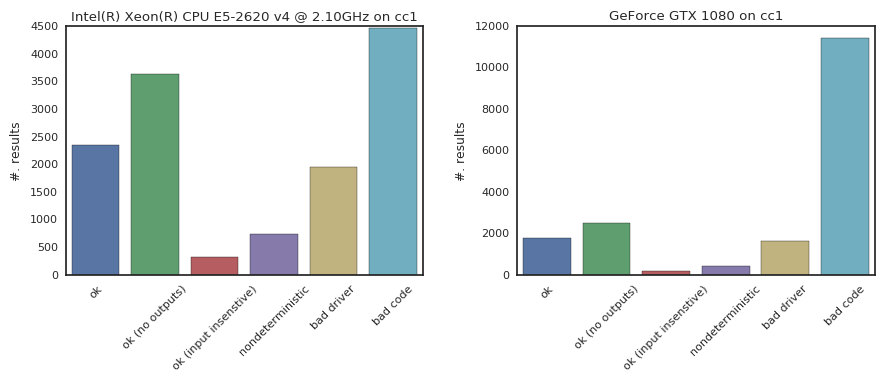

In [4]:
STATUS = ["ok", "ok (no outputs)", "ok (input insenstive)", "nondeterministic", "bad driver", "bad code"]

def plot_dist(path):
    basename = fs.basename(path)
    c = dbutil.connect(path).cursor()
    c.execute("SELECT status, COUNT(status) FROM Data GROUP BY status ORDER BY status")
    d = [{"status": STATUS[i], "n": x} for i, x in c.fetchall()]
    ax = sns.barplot(x="status", y="n", data=pd.DataFrame(d))
    device = dbutil.get_meta(path, "device")
    host = dbutil.get_meta(path, "host")
    plt.title("{device} on {host}".format(**vars()))
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
    plt.xlabel("")
    plt.ylabel("#. results")

ax = plt.subplot(1, 2, 1)
plot_dist(in1)
ax = plt.subplot(1, 2, 2)
plot_dist(in2)

viz.finalise(figsize=(9, 4))

### Generate reports

In [5]:
# write report files to:
reportdir = "data/difftest/reports"
fs.mkdir(reportdir)

!rm data/difftest/reports/*.txt

In [6]:
from difflib import unified_diff
import sys
from clgen.clutil import KernelPrototype

numstatusdiff = 0
numdatadiff = 0

def get_src(c, id):
    c.execute("SELECT Source FROM Source WHERE id=?", (id,))
    r = c.fetchone()
    assert(len(r) == 1)
    return r[0]

for row in cdata:
    id, lstatus, rstatus, ldata, rdata = row

    if ldata != rdata:
        reportpath = fs.path(reportdir, "{id}-data.txt".format(**vars()))
        print("Data diff:", fs.basename(reportpath))        

        src1 = get_src(c1, id)
        src2 = get_src(c2, id)
        assert(src1 == src2)  # sanity check for hash collisions

        src_size = len(src1.split('\n'))
        prototype = KernelPrototype.from_source(src1)
        
        report = """\
===================================================
Kernel {id} ({src_size} lines):
===================================================

{src1}
""".format(**vars())
        
        srcpath = fs.path(reportdir, "{id}".format(**vars()))
        with open(srcpath, "w") as outfile:
            print(src1, file=outfile)
            
        ld = json.loads(ldata)
        rd = json.loads(rdata)
        assert(len(ld) == len(rd))  # payloads should have same length
        for i, r in enumerate(zip(ld, rd)):
            a1, a2 = r
            if a1 != a2:
                assert(len(a1) == len(a2))
   
                argtype = prototype.args[i]
                t1 = ["{}\n".format(x) for x in a1]
                t2 = ["{}\n".format(x) for x in a2]

                diff = list(unified_diff(t1, t2, fromfile=device1, tofile=device2))
                diff_size = len(diff)
                diff = ''.join(diff)

                report += """\

===================================================
Output diff ({diff_size} lines) for arg {i}: {argtype}
===================================================

{diff}
""".format(**vars())
        
        with open(reportpath, "w") as reportfile:
            print(report, file=reportfile)
        numdatadiff += 1
    elif lstatus != rstatus:
        reportpath = fs.path(reportdir, "{id}-status.txt".format(**vars()))
        print("Status mismatch:", fs.basename(reportpath))
        
        STATUS = ["ok", "ok (no outputs)", "ok (input insenstive)", "nondeterministic", "bad driver", "bad code"]
        lstatus_txt = STATUS[lstatus]
        rstatus_txt = STATUS[rstatus]
        
        src1 = get_src(c1, id)
        src2 = get_src(c2, id)
        assert(src1 == src2)  # sanity check for hash collisions

        src_size = len(src1.split('\n'))

        report = """\
===================================================
Kernel {id} ({src_size} lines):
===================================================

{src1}

===================================================
Status mismatch:
===================================================

On {device1}: {lstatus_txt}
On {device2}: {rstatus_txt}
""".format(**vars())
        
        with open(reportpath, "w") as reportfile:
            print(report, file=reportfile)
        numstatusdiff += 1

ratiostatusdiff = numstatusdiff / len(cdata)
ratiodatadiff = numdatadiff / len(cdata)

Data diff: 2706a7641f6178a675e80452fbfeca7ff3102b61.cl-data.txt
Status mismatch: dcae239e1575c36df29326d586a6f9d70e57fb43.cl-status.txt
Status mismatch: 9a16d4ce0fc164cb819a2a7c1508db9bd46629b5.cl-status.txt
Data diff: e6b800e780afb35834c7d3ae96bbe57614e672fd.cl-data.txt
Data diff: 8438b222e9a30fee8e0ba7910f1cd16d0c6ff9e8.cl-data.txt
Data diff: 1ba6c22be25beda62bbef93cffec60c7c0970aae.cl-data.txt
Data diff: 2a7583ba751fcc43999838e557f4257c58ce485e.cl-data.txt
Data diff: 3de6c77341cfe05fe061ccbded043992094a170e.cl-data.txt
Data diff: d745ff1ac43d192305833d0eee51df7cb8471603.cl-data.txt
Data diff: cc4bd1b35e3f5181dc8bb084588ab48b24f349a4.cl-data.txt
Data diff: cb21ab8e7056fa503d2d6100229cdae10aa26551.cl-data.txt
Data diff: 2e202fb8472dd387791f1135f7e66e14e0c530cf.cl-data.txt
Data diff: 19f51ce8f48716a0aea3083ceb1cf3453dacbec5.cl-data.txt
Data diff: c3931a439a77f4130dcdd8874840b9b126348a42.cl-data.txt
Data diff: 78434994bda77b8c9fb6b50d68be4e73b98b8151.cl-data.txt
Data diff: 1df64378ef0bf

In [7]:
print("Found {numstatusdiff} ({ratiostatusdiff:.2%}) cases with different statuses".format(**vars()))
print("Found {numdatadiff} ({ratiodatadiff:.2%}) cases with different data".format(**vars()))

Found 4 (0.43%) cases with different statuses
Found 64 (6.81%) cases with different data


## Invesitgating diff kernels

"diff" kernels are those which have a difference in the computed data or runtime status when ran on different hardware.

**TODO:**
* Run [GPUverify](http://multicore.doc.ic.ac.uk/tools/GPUVerify/) on these kernels.
* Run [Oclgrind](https://github.com/jrprice/Oclgrind) on these kernels.

In [8]:
from clgen import preprocess
help(preprocess.gpuverify)

Help on function gpuverify in module clgen.preprocess:

gpuverify(src:str, args:list, id:str='anon') -> str
    Run GPUverify over kernel.
    
    Arguments:
        src (str): OpenCL source.
        id (str, optional): OpenCL source name.
    
    Returns:
        str: OpenCL source.
    
    Raises:
        GPUVerifyException: If GPUverify finds a bug.
        InternalError: If GPUverify fails.



In [9]:
with open(fs.path("~/src/project_b/data/difftest/reports/2edf9e7802bc5fe0cf00cd99e55bd7cb53bbfbf6.cl")) as infile:
    src = infile.read()
print(src)

__kernel void A(__global ushort* a, __global ushort* b, __global ushort* c) {
  int d = (int)get_global_id(0);
  c[d] = a[d] % b[d];
}



In [10]:
preprocess.gpuverify(src, ["--local_size=64", "--num_groups=128"])

'__kernel void A(__global ushort* a, __global ushort* b, __global ushort* c) {\n  int d = (int)get_global_id(0);\n  c[d] = a[d] % b[d];\n}\n'

In [15]:
import sys
kernels = [x for x in fs.ls(fs.path("data/difftest/reports"), abspaths=True) if x.endswith(".cl")]

err_count = 0
for path in kernels:
    with open(path) as infile:
        print(path)
        src = infile.read()
        try:
            preprocess.gpuverify(src, ["--local_size=64", "--num_groups=128"])
        except preprocess.GPUVerifyException as e:
            err_count += 1
            print(e, file=sys.stderr)
            
print("total number of errors:", err_count)

/home/cec/src/project_b/data/difftest/reports/04a16f578844d69c2a807dd494d7017af29d245a.cl
/home/cec/src/project_b/data/difftest/reports/0ed6e85e4289df27e83830231e3abf60742d6695.cl



/tmp/tmpde03h7dw.cl: error: possible write-read race on a[48]:

Read by work item 16 with local id 16 in work group 0, /tmp/tmpde03h7dw.cl:5:29:
  a[get_local_id(0)] += a[get_local_id(0) + b];

Write by work item 1072 with local id 48 in work group 16, /tmp/tmpde03h7dw.cl:5:26:
  a[get_local_id(0)] += a[get_local_id(0) + b];


/tmp/tmpde03h7dw.cl: error: possible write-read race on a[0]:

Read by work item 0 with local id 0 in work group 0, /tmp/tmpde03h7dw.cl:5:26:
  a[get_local_id(0)] += a[get_local_id(0) + b];

Write by work item 1024 with local id 0 in work group 16, /tmp/tmpde03h7dw.cl:5:26:
  a[get_local_id(0)] += a[get_local_id(0) + b];


/tmp/tmpde03h7dw.cl: error: possible read-write race on a[16]:

Write by work item 16 with local id 16 in work group 0, /tmp/tmpde03h7dw.cl:5:26:
  a[get_local_id(0)] += a[get_local_id(0) + b];

Read by work item 1025 with local id 1 in work group 16, possible sources are:
/tmp/tmpde03h7dw.cl:5:26:
  a[get_local_id(0)] += a[get_local_id(0) + b

/home/cec/src/project_b/data/difftest/reports/17e6c8bcee409d5db27fbbc60f22e58e50aed6d6.cl
/home/cec/src/project_b/data/difftest/reports/19f51ce8f48716a0aea3083ceb1cf3453dacbec5.cl
/home/cec/src/project_b/data/difftest/reports/1ba6c22be25beda62bbef93cffec60c7c0970aae.cl


tmpa3p8zlon.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmpa3p8zlon.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpa3p8zlon.cl: error: possible read-write race on b[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpa3p8zlon.cl:4:23:
  b[get_global_id(0)] = 2 * b[get_local_id(0)];

Read by work item 64 with local id 0 in work group 1, /tmp/tmpa3p8zlon.cl:4:29:
  b[get_global_id(0)] = 2 * b[get_local_id(0)];




/home/cec/src/project_b/data/difftest/reports/1df64378ef0bf6c406b2cb0ccc1012ddd6f65c60.cl


/tmp/tmpl8woad2s.cl:6:7: warning: unused variable 'i' [-Wunused-variable]
  int i = get_group_id(0);
      ^
/tmp/tmpl8woad2s.cl:10:9: warning: variable 'f' is uninitialized when used here [-Wuninitialized]
    f = f * f;
        ^
/tmp/tmpl8woad2s.cl:2:14: note: initialize the variable 'f' to silence this warning
  int d, e, f, g;
             ^
              = 0
/tmp/tmpl8woad2s.cl:9:9: warning: variable 'd' is uninitialized when used here [-Wuninitialized]
    g = d * h + g;
        ^
/tmp/tmpl8woad2s.cl:2:8: note: initialize the variable 'd' to silence this warning
  int d, e, f, g;
       ^
        = 0
/tmp/tmpl8woad2s.cl:8:7: warning: variable 'g' is uninitialized when used here [-Wuninitialized]
  if (g < 1 && g < e) {
      ^
/tmp/tmpl8woad2s.cl:2:17: note: initialize the variable 'g' to silence this warning
  int d, e, f, g;
                ^
                 = 0
4 warnings generated.
tmpl8woad2s.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tm

/home/cec/src/project_b/data/difftest/reports/1e7ec8f208eaf040e25f9bae47232c17d9b5892d.cl


/tmp/tmpof5d76tm.cl:3:7: warning: unused variable 'g' [-Wunused-variable]
  int g = get_global_id(1);
      ^
1 warning generated.
tmpof5d76tm.opt.bc: warning: Assuming the arguments 'a', 'b', 'c', 'd', 'e' of 'A' on line 1 of /tmp/tmpof5d76tm.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpof5d76tm.cl: error: possible read-write race on e[1]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpof5d76tm.cl:5:10:
  e[1] += -1;

Read by work item 1 with local id 1 in work group 0, /tmp/tmpof5d76tm.cl:5:10:
  e[1] += -1;




/home/cec/src/project_b/data/difftest/reports/20e78fde43680b5832a80409fa64ae99dec36fd7.cl
/home/cec/src/project_b/data/difftest/reports/255409f28fe8056cf6072e6de09a7d1b86f4a23e.cl



/tmp/tmpypbq_qkm.cl: error: possible read-write race on a[2]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpypbq_qkm.cl:2:27:
  a[get_global_id(0) + 2] = a[get_global_id(0)];

Read by work item 2 with local id 2 in work group 0, /tmp/tmpypbq_qkm.cl:2:29:
  a[get_global_id(0) + 2] = a[get_global_id(0)];




/home/cec/src/project_b/data/difftest/reports/26496231dee4b4696b399b9caab80e57e37047a7.cl
/home/cec/src/project_b/data/difftest/reports/2706a7641f6178a675e80452fbfeca7ff3102b61.cl


/tmp/tmpy7jkyvgo.cl:2:7: warning: unused variable 'c' [-Wunused-variable]
  int c[32];
      ^
1 warning generated.
tmpy7jkyvgo.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmpy7jkyvgo.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpy7jkyvgo.cl: error: possible write-read race on a[1]:

Read by work item 4 with local id 4 in work group 0, /tmp/tmpy7jkyvgo.cl:7:10:
  a[e] += b[e];

Write by work item 64 with local id 0 in work group 1, /tmp/tmpy7jkyvgo.cl:7:10:
  a[e] += b[e];


/tmp/tmpy7jkyvgo.cl: error: possible read-write race on a[1]:

Write by work item 4 with local id 4 in work group 0, /tmp/tmpy7jkyvgo.cl:7:10:
  a[e] += b[e];

Read by work item 64 with local id 0 in work group 1, /tmp/tmpy7jkyvgo.cl:7:10:
  a[e] += b[e];


/tmp/tmpy7jkyvgo.cl: error: possible write-write race on a[1]:

Write by work item 4 with local id 4 in work group 0, /tmp/tmpy7jkyvgo.cl:7:10:
  a[e] += b[e];

Write by work item 64 w

/home/cec/src/project_b/data/difftest/reports/2a7583ba751fcc43999838e557f4257c58ce485e.cl


tmp8px73ahb.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmp8px73ahb.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp8px73ahb.cl:12:3: error: barrier may be reached by non-uniform control flow
  barrier(1);

Bitwise values of parameters of 'A':
  c = 1
  d = 1


/tmp/tmp8px73ahb.cl: error: possible read-write race on a[1]:

Write by work item 1 with local id 1 in work group 0, /tmp/tmp8px73ahb.cl:18:8:
  a[c] += d;

Read by work item 8 with local id 8 in work group 0, /tmp/tmp8px73ahb.cl:18:8:
  a[c] += d;

Bitwise values of parameters of 'A':
  c = 1
  d = 12




/home/cec/src/project_b/data/difftest/reports/2e202fb8472dd387791f1135f7e66e14e0c530cf.cl


/tmp/tmpamqhvjw5.cl:6:5: warning: variable 'f' is uninitialized when used here [-Wuninitialized]
  d[f] = a[e];
    ^
/tmp/tmpamqhvjw5.cl:2:8: note: initialize the variable 'f' to silence this warning
  int f;
       ^
        = 0
1 warning generated.
tmpamqhvjw5.opt.bc: warning: Assuming the arguments 'a', 'b', 'c', 'd' of 'A' on line 1 of /tmp/tmpamqhvjw5.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpamqhvjw5.cl: error: possible write-write race on d[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpamqhvjw5.cl:6:8:
  d[f] = a[e];

Write by work item 65 with local id 1 in work group 1, /tmp/tmpamqhvjw5.cl:6:8:
  d[f] = a[e];

Bitwise values of parameters of 'A':
  e = <irrelevant>




/home/cec/src/project_b/data/difftest/reports/2e218b0e3e8f74eb3410a95de77bc10f91417612.cl
/home/cec/src/project_b/data/difftest/reports/2edf9e7802bc5fe0cf00cd99e55bd7cb53bbfbf6.cl
/home/cec/src/project_b/data/difftest/reports/2fe3a72f1e60cb450d821ec61704bb9a74680fe6.cl
/home/cec/src/project_b/data/difftest/reports/3de6c77341cfe05fe061ccbded043992094a170e.cl
/home/cec/src/project_b/data/difftest/reports/3e42e3b385260a4dd4e74c522bf777313d394487.cl
/home/cec/src/project_b/data/difftest/reports/422c8160a26b3c757c13021c74b195547e40456c.cl
/home/cec/src/project_b/data/difftest/reports/4689740817172b7a4fd627707cc5b391637607d6.cl


tmp3w2aqbp5.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tmp3w2aqbp5.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp3w2aqbp5.cl: error: possible write-write race on a[3]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmp3w2aqbp5.cl:6:8:
  a[d] = c[d] + c[d];

Write by work item 2 with local id 2 in work group 0, /tmp/tmp3w2aqbp5.cl:6:8:
  a[d] = c[d] + c[d];

Bitwise values of parameters of 'A':
  d = 3




/home/cec/src/project_b/data/difftest/reports/56e4ac3401d595b6f177d09bbc907a95f00a5484.cl
/home/cec/src/project_b/data/difftest/reports/5a3188ee0d18f6f2bf890d377de62a82dd1316e2.cl
/home/cec/src/project_b/data/difftest/reports/5b5e8a390ad181d14d340d20daed8f0a602530bb.cl


/tmp/tmpx3pyzjhk.cl:6:9: warning: ordered comparison between pointer and integer ('int' and '__global float *')
  if (e < c) {
      ~ ^ ~
/tmp/tmpx3pyzjhk.cl:5:7: warning: unused variable 'f' [-Wunused-variable]
  int f = e * d;
      ^
2 warnings generated.
tmpx3pyzjhk.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tmpx3pyzjhk.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpx3pyzjhk.cl: error: possible read-write race on b[1]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpx3pyzjhk.cl:7:10:
  b[e] += b[e + 3];

Read by work item 65 with local id 1 in work group 1, /tmp/tmpx3pyzjhk.cl:7:10:
  b[e] += b[e + 3];




/home/cec/src/project_b/data/difftest/reports/65932dd44f7c37444488d1950ed6c6753e703d1b.cl


tmp7dsfge1p.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmp7dsfge1p.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp7dsfge1p.cl: error: possible write-write race on b[1]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmp7dsfge1p.cl:6:27:
  b[get_global_id(0) + 1] = b[get_global_id(0)];

Write by work item 1 with local id 1 in work group 0, /tmp/tmp7dsfge1p.cl:3:8:
  b[1] = b[10];


/tmp/tmp7dsfge1p.cl: error: possible read-write race on b[1089]:

Write by work item 1088 with local id 0 in work group 17, /tmp/tmp7dsfge1p.cl:6:27:
  b[get_global_id(0) + 1] = b[get_global_id(0)];

Read by work item 1089 with local id 1 in work group 17, /tmp/tmp7dsfge1p.cl:6:29:
  b[get_global_id(0) + 1] = b[get_global_id(0)];


/tmp/tmp7dsfge1p.cl: error: possible read-write race on b[0]:

Write by work item 1 with local id 1 in work group 0, /tmp/tmp7dsfge1p.cl:7:6:
  *b = clz(*a);

Read by work item 0 with local i

/home/cec/src/project_b/data/difftest/reports/68b3a692863975742bf5541b04c321b06c7d6e6e.cl


tmplypcukfv.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmplypcukfv.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmplypcukfv.cl: error: possible write-write race on b[0] (bytes 0..3):

Write by work item 4096 with local id 0 in work group 64, /tmp/tmplypcukfv.cl:2:8:
  b[0] = a[get_global_id(0)] * 2;

Write by work item 1 with local id 1 in work group 0, /tmp/tmplypcukfv.cl:2:8:
  b[0] = a[get_global_id(0)] * 2;


/tmp/tmplypcukfv.cl: error: possible write-write race on b[0] (bytes 4..7):

Write by work item 4096 with local id 0 in work group 64, /tmp/tmplypcukfv.cl:2:8:
  b[0] = a[get_global_id(0)] * 2;

Write by work item 1 with local id 1 in work group 0, /tmp/tmplypcukfv.cl:2:8:
  b[0] = a[get_global_id(0)] * 2;


/tmp/tmplypcukfv.cl: error: possible write-write race on b[0] (bytes 8..11):

Write by work item 4096 with local id 0 in work group 64, /tmp/tmplypcukfv.cl:2:8:
  b[0] = a[get_global_id(0)] * 2;



/home/cec/src/project_b/data/difftest/reports/6fb9d002f73b4d430bbd799d118c9d3ea043afc5.cl


tmpw9rq623d.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmpw9rq623d.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpw9rq623d.cl: error: possible write-write race on b[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpw9rq623d.cl:3:8:
  b[0] = a[c];

Write by work item 65 with local id 1 in work group 1, /tmp/tmpw9rq623d.cl:3:8:
  b[0] = a[c];




/home/cec/src/project_b/data/difftest/reports/78434994bda77b8c9fb6b50d68be4e73b98b8151.cl


tmp6xcqtydw.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmp6xcqtydw.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp6xcqtydw.cl: error: possible write-write race on a[0]:

Write by work item 1 with local id 1 in work group 0, /tmp/tmp6xcqtydw.cl:5:10:
  a[d] = b[d] * c;

Write by work item 2 with local id 2 in work group 0, /tmp/tmp6xcqtydw.cl:5:10:
  a[d] = b[d] * c;




/home/cec/src/project_b/data/difftest/reports/78663bf3a85a4c870485e7049a19e85f1b8ca9e8.cl
/home/cec/src/project_b/data/difftest/reports/797cc4722f7d767fd04f845224c9faefcdd211b4.cl


/tmp/tmpus9fhoaq.cl:3:9: warning: ordered comparison between pointer and integer ('int' and '__global int *')
  if (d >= c)
      ~ ^  ~
1 warning generated.
tmpus9fhoaq.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tmpus9fhoaq.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpus9fhoaq.cl: error: possible read-write race on c[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpus9fhoaq.cl:5:8:
  c[d] = c[d] + c[d % 64];

Read by work item 128 with local id 0 in work group 2, /tmp/tmpus9fhoaq.cl:5:17:
  c[d] = c[d] + c[d % 64];




/home/cec/src/project_b/data/difftest/reports/7a185bdce5d0592df89c909c997fe2c06167bae6.cl


tmp66kixmmn.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tmp66kixmmn.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp66kixmmn.cl: error: possible write-write race on c[2]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmp66kixmmn.cl:5:12:
  c[d + 2] = a[d + 1];

Write by work item 2 with local id 2 in work group 0, /tmp/tmp66kixmmn.cl:4:12:
  c[d + 0] = a[d + 0] + b[d + 0];


/tmp/tmp66kixmmn.cl: error: possible write-write race on c[2]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmp66kixmmn.cl:6:12:
  c[d + 2] = a[d + 2] - b[d + 3];

Write by work item 2 with local id 2 in work group 0, /tmp/tmp66kixmmn.cl:4:12:
  c[d + 0] = a[d + 0] + b[d + 0];




/home/cec/src/project_b/data/difftest/reports/7e9e6f3a63e717f71a40b4ca2eb61955dc4922ce.cl



/tmp/tmp39n1jmqa.cl: error: possible write-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmp39n1jmqa.cl:4:23:
  a[get_global_id(0)] = 0;

Write by work item 64 with local id 0 in work group 1, /tmp/tmp39n1jmqa.cl:2:22:
  a[get_local_id(0)] = get_local_id(0);




/home/cec/src/project_b/data/difftest/reports/81e5c6965b73f0d23e0e69b8a8120f3363457005.cl


/tmp/tmpioqvxdb0.cl:2:7: warning: unused variable 'b' [-Wunused-variable]
  int b = get_global_id(0);
      ^
1 warning generated.

/tmp/tmpioqvxdb0.cl: error: possible read-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpioqvxdb0.cl:4:24:
  a[get_local_id(0)] = a[get_local_id(0)] + 1.0f;

Read by work item 64 with local id 0 in work group 1, /tmp/tmpioqvxdb0.cl:4:26:
  a[get_local_id(0)] = a[get_local_id(0)] + 1.0f;




/home/cec/src/project_b/data/difftest/reports/8438b222e9a30fee8e0ba7910f1cd16d0c6ff9e8.cl



/tmp/tmp9562h7nr.cl: error: possible read-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmp9562h7nr.cl:2:7:
  a[0]++;

Read by work item 65 with local id 1 in work group 1, /tmp/tmp9562h7nr.cl:2:7:
  a[0]++;




/home/cec/src/project_b/data/difftest/reports/8636af9dc8212f5eefbe33f81ff6b262e5c2d566.cl


tmpd29hmqai.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmpd29hmqai.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpd29hmqai.cl: error: possible write-write race on a[0]:

Write by work item 4096 with local id 0 in work group 64, /tmp/tmpd29hmqai.cl:2:8:
  a[0] = get_global_id(0);

Write by work item 0 with local id 0 in work group 0, /tmp/tmpd29hmqai.cl:2:8:
  a[0] = get_global_id(0);


/tmp/tmpd29hmqai.cl: error: possible write-read race on b[0]:

Read by work item 4096 with local id 0 in work group 64, /tmp/tmpd29hmqai.cl:4:25:
  a[get_global_id(0)] = b[get_local_id(0)];

Write by work item 0 with local id 0 in work group 0, /tmp/tmpd29hmqai.cl:3:23:
  b[get_global_id(0)] = get_local_id(1);




/home/cec/src/project_b/data/difftest/reports/8738e95338f5b843f92a72b0520f97cca46b1ed9.cl
/home/cec/src/project_b/data/difftest/reports/89d1fa1256f997f376690c903cba1f8652e43bf1.cl


tmpfw04mkcm.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tmpfw04mkcm.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpfw04mkcm.cl: error: possible write-write race on c[1]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpfw04mkcm.cl:4:12:
  c[d + 1] = a[d + 1] & b[d];

Write by work item 1 with local id 1 in work group 0, /tmp/tmpfw04mkcm.cl:3:8:
  c[d] = a[d] + b[d];




/home/cec/src/project_b/data/difftest/reports/8a5af2af494b578f66f3053d7db22dad097e5ebd.cl
/home/cec/src/project_b/data/difftest/reports/956ce221a3637da86d18478ce59aaa2d653852ec.cl


/tmp/tmp82he6k7e.cl:2:7: warning: unused variable 'c' [-Wunused-variable]
  int c[16];
      ^
1 warning generated.
tmp82he6k7e.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmp82he6k7e.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp82he6k7e.cl: error: possible write-read race on a[0]:

Read by work item 4 with local id 4 in work group 0, /tmp/tmp82he6k7e.cl:6:12:
  a[e] += b[e];

Write by work item 64 with local id 0 in work group 1, /tmp/tmp82he6k7e.cl:6:12:
  a[e] += b[e];


/tmp/tmp82he6k7e.cl: error: possible read-write race on a[0]:

Write by work item 4 with local id 4 in work group 0, /tmp/tmp82he6k7e.cl:6:12:
  a[e] += b[e];

Read by work item 64 with local id 0 in work group 1, /tmp/tmp82he6k7e.cl:6:12:
  a[e] += b[e];


/tmp/tmp82he6k7e.cl: error: possible write-write race on a[0]:

Write by work item 4 with local id 4 in work group 0, /tmp/tmp82he6k7e.cl:6:12:
  a[e] += b[e];

Write by work item 64 w

/home/cec/src/project_b/data/difftest/reports/9af2073dfc983267f7895897c94124c31af40903.cl
/home/cec/src/project_b/data/difftest/reports/9d29169a3ea3d5bb80f7234f6c2cd97484b7b8c5.cl
/home/cec/src/project_b/data/difftest/reports/a9258b916a92fa2c189c94276d2ddd4341f16038.cl
/home/cec/src/project_b/data/difftest/reports/adc686ee51cca3710bd40a02053a73fdc73d94ae.cl


/tmp/tmp60yf62kb.cl:2:7: warning: unused variable 'f' [-Wunused-variable]
  int f = get_global_id(0);
      ^
/tmp/tmp60yf62kb.cl:3:7: warning: unused variable 'g' [-Wunused-variable]
  int g = a[d];
      ^
2 warnings generated.
tmp60yf62kb.opt.bc: warning: Assuming the arguments 'c', 'd', 'e' of 'A' on line 1 of /tmp/tmp60yf62kb.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp60yf62kb.cl: error: possible read-write race on d[0]:

Write by work item 1024 with local id 0 in work group 16, /tmp/tmp60yf62kb.cl:4:8:
  a[d] = e - d;

Read by work item 8 with local id 8 in work group 0, /tmp/tmp60yf62kb.cl:3:13:
  int g = a[d];

Bitwise values of parameters of 'A':
  a = 0
  b = <irrelevant>




/home/cec/src/project_b/data/difftest/reports/b3b9b0bc3d558a92c7077cbe39e0e7b4e4f9a8f5.cl
/home/cec/src/project_b/data/difftest/reports/b51b307903d763b4307ea9ca638d9a239f716ed3.cl


tmp_x0rfg0r.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmp_x0rfg0r.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmp_x0rfg0r.cl: error: possible write-write race on a[64]:

Write by work item 63 with local id 63 in work group 0, /tmp/tmp_x0rfg0r.cl:6:27:
  a[get_global_id(0) + 1] = get_global_id(0);

Write by work item 64 with local id 0 in work group 1, /tmp/tmp_x0rfg0r.cl:2:23:
  a[get_global_id(0)] = get_global_id(0);




/home/cec/src/project_b/data/difftest/reports/c3931a439a77f4130dcdd8874840b9b126348a42.cl
/home/cec/src/project_b/data/difftest/reports/c39bdd07980a3ea026aaf091a5108a4d787d5cb4.cl
/home/cec/src/project_b/data/difftest/reports/c3a9bfc99018dbac0fb18ec041661d46d423dc00.cl
/home/cec/src/project_b/data/difftest/reports/c7a2276115e39e10e2f557c70c3e4f6274064e19.cl
/home/cec/src/project_b/data/difftest/reports/c8e8fc25ae9e7bda2ef21fd9e29992ae97609236.cl


/tmp/tmp1aiw6bav.cl:3:10: error: implicit declaration of function 'lgamma_r' is invalid in C99 [-Werror,-Wimplicit-function-declaration]
  b[d] = lgamma_r(a[d], c + d);
         ^
1 error generated.



/home/cec/src/project_b/data/difftest/reports/cb21ab8e7056fa503d2d6100229cdae10aa26551.cl



/tmp/tmpb56jo1j6.cl: error: possible write-read race on a[0]:

Read by work item 0 with local id 0 in work group 0, /tmp/tmpb56jo1j6.cl:3:10:
  a[b] *= 2;

Write by work item 65 with local id 1 in work group 1, /tmp/tmpb56jo1j6.cl:3:10:
  a[b] *= 2;


/tmp/tmpb56jo1j6.cl: error: possible read-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpb56jo1j6.cl:3:10:
  a[b] *= 2;

Read by work item 65 with local id 1 in work group 1, /tmp/tmpb56jo1j6.cl:3:10:
  a[b] *= 2;


/tmp/tmpb56jo1j6.cl: error: possible write-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpb56jo1j6.cl:3:10:
  a[b] *= 2;

Write by work item 65 with local id 1 in work group 1, /tmp/tmpb56jo1j6.cl:3:10:
  a[b] *= 2;




/home/cec/src/project_b/data/difftest/reports/cc4bd1b35e3f5181dc8bb084588ab48b24f349a4.cl


/tmp/tmpuru9w3nf.cl:4:24: warning: incompatible pointer types passing '__global int **' to parameter of type '__bugle_event_t *' (aka 'unsigned int *') [-Wincompatible-pointer-types]
  wait_group_events(1, &a);
                       ^~
/home/cec/clgen/lib/python3.5/site-packages/CLgen-0.2.7-py3.5.egg/clgen/data/gpuverify/bugle/include-blang/clc/async/wait_group_events.h:1:57: note: passing argument to parameter 'event_list' here
void __bugle_wait_group_events(int num_events, event_t *event_list);
                                                        ^
1 warning generated.
tmpuru9w3nf.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmpuru9w3nf.cl to be non-aliased; please consider adding a restrict qualifier to these arguments
tmpuru9w3nf.opt.bc: error: wait_group_events with cast set of events not supported
Please contact the developers; this is an implementation limitation



/home/cec/src/project_b/data/difftest/reports/cd6d6de046fcd79e1b31ed35ebc1062a2721378c.cl


/tmp/tmpeizmir8w.cl:9:9: warning: comparison between pointer and integer ('int' and '__global float *')
  if (d != b) {
      ~ ^  ~
1 warning generated.
tmpeizmir8w.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tmpeizmir8w.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpeizmir8w.cl: error: possible write-write race on c[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpeizmir8w.cl:5:8:
  c[e] = a[d];

Write by work item 64 with local id 0 in work group 1, /tmp/tmpeizmir8w.cl:5:8:
  c[e] = a[d];


/tmp/tmpeizmir8w.cl: error: possible write-read race on c[1]:

Read by work item 0 with local id 0 in work group 0, /tmp/tmpeizmir8w.cl:10:17:
  b[e] += e[c + 1];

Write by work item 65 with local id 1 in work group 1, /tmp/tmpeizmir8w.cl:5:8:
  c[e] = a[d];


/tmp/tmpeizmir8w.cl: error: possible read-write race on b[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpeizmir8w.cl:10:

/home/cec/src/project_b/data/difftest/reports/d119d5ebb05f11f7859568499d5f9e54d002eda7.cl



/tmp/tmp3z25w59w.cl: error: possible read-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmp3z25w59w.cl:2:6:
  *a += 10;

Read by work item 65 with local id 1 in work group 1, /tmp/tmp3z25w59w.cl:2:6:
  *a += 10;




/home/cec/src/project_b/data/difftest/reports/d554f7034b79009041967428ec18bcfc633f149f.cl
/home/cec/src/project_b/data/difftest/reports/d745ff1ac43d192305833d0eee51df7cb8471603.cl
/home/cec/src/project_b/data/difftest/reports/d7a75ff493af21b74b40292ea0f81fd681f72b48.cl



/tmp/tmpcmr5zedi.cl: error: possible write-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpcmr5zedi.cl:4:23:
  a[get_global_id(0)] = a[2];

Write by work item 1 with local id 1 in work group 0, /tmp/tmpcmr5zedi.cl:2:8:
  a[0] = 42;




/home/cec/src/project_b/data/difftest/reports/e32e15e81a1470f695a323479c50533b0e3da388.cl



/tmp/tmp6kr1enfp.cl:4:7: error: barrier may be reached by non-uniform control flow
  barrier(1);




/home/cec/src/project_b/data/difftest/reports/e6b800e780afb35834c7d3ae96bbe57614e672fd.cl


tmpc_2x1ya1.opt.bc: warning: Assuming the arguments 'a', 'b', 'c' of 'A' on line 1 of /tmp/tmpc_2x1ya1.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpc_2x1ya1.cl: error: possible write-write race on a[1929317326]:

Write by work item 7685 with local id 5 in work group 120, /tmp/tmpc_2x1ya1.cl:5:19:
  a[d * (*c) + 0] = acos(e);

Write by work item 7569 with local id 17 in work group 118, /tmp/tmpc_2x1ya1.cl:5:19:
  a[d * (*c) + 0] = acos(e);


/tmp/tmpc_2x1ya1.cl: error: possible write-write race on a[1538]:

Write by work item 1541 with local id 5 in work group 24, /tmp/tmpc_2x1ya1.cl:6:19:
  a[d * (*c) + 2] = asin(e);

Write by work item 8144 with local id 16 in work group 127, /tmp/tmpc_2x1ya1.cl:6:19:
  a[d * (*c) + 2] = asin(e);


/tmp/tmpc_2x1ya1.cl: error: possible write-write race on a[1538]:

Write by work item 1538 with local id 2 in work group 24, /tmp/tmpc_2x1ya1.cl:7:8:
  a[d] = d;

Write by work item 8144 with local id 16 in w

/home/cec/src/project_b/data/difftest/reports/ea4b51a499933c2586b1fff6109cb8061e989680.cl
/home/cec/src/project_b/data/difftest/reports/ee8a2e6632acc975c3f31b0779cded670bcc0c48.cl
/home/cec/src/project_b/data/difftest/reports/f180a86f847d4c721ed3b1a3c81374aafef7aa81.cl



/tmp/tmpoi5u0n1i.cl: error: possible read-write race on a[0]:

Write by work item 0 with local id 0 in work group 0, /tmp/tmpoi5u0n1i.cl:2:6:
  *a *= -12.0f;

Read by work item 65 with local id 1 in work group 1, /tmp/tmpoi5u0n1i.cl:2:6:
  *a *= -12.0f;




/home/cec/src/project_b/data/difftest/reports/faa7dea520abcb9a526d6243f6d9b32659b657b0.cl


/tmp/tmpsddtp1_l.cl:7:7: warning: unused variable 'f' [-Wunused-variable]
  int f = d * e + d;
      ^
1 warning generated.
tmpsddtp1_l.opt.bc: warning: Assuming the arguments 'a', 'b' of 'A' on line 1 of /tmp/tmpsddtp1_l.cl to be non-aliased; please consider adding a restrict qualifier to these arguments

/tmp/tmpsddtp1_l.cl: error: possible write-write race on a[0]:

Write by work item 2 with local id 2 in work group 0, /tmp/tmpsddtp1_l.cl:8:8:
  a[c] = b[e];

Write by work item 0 with local id 0 in work group 0, /tmp/tmpsddtp1_l.cl:8:8:
  a[c] = b[e];

Bitwise values of parameters of 'A':
  c = 0
  d = 3




/home/cec/src/project_b/data/difftest/reports/fb4547b1c0e4b251a6d3fb9d30d90a9b95fe2555.cl
/home/cec/src/project_b/data/difftest/reports/fd3f74620c0042b5187e0b4bdc62ef02147f9dbe.cl
total number of errors: 34


In [16]:
print(len(kernels))

64
